# Решение задачи:

Установка необходимых библиотек:

In [ ]:
!pip install gym numpy torch matplotlib > /dev/null 2>&1

Импорт библиотек и создание среды:

In [ ]:
import gymnasium as gym
import torch
# Фикс для np.bool8 (не все библиотеки обновились вслед за numpy)
import numpy as np
np.bool8 = np.bool_  # или bool
from collections import defaultdict
import matplotlib.pyplot as plt
import math

# Создание среды MountainCar
env = gym.make('MountainCar-v0')

Определяются параметры для преобразования непрерывных состояний в дискретные **bins** (30 для позиции и скорости). Это позволяет использовать табличный метод **MC**, где **Q** — словарь с ключами (`pos_bin`, `vel_bin`). 30x30=900 состояний:

In [ ]:
# Параметры дискретизации состояний
num_pos_bins = 30
num_vel_bins = 30
pos_bins = np.linspace(-1.2, 0.6, num_pos_bins)
vel_bins = np.linspace(-0.07, 0.07, num_vel_bins)

Следующая функция преобразует непрерывное состояние **[pos, vel]** в дискретный кортеж (`pos_idx`, `vel_idx`) с помощью `np.digitize`:

In [ ]:
# Функция для дискретизации состояния
def discretize_state(state):
    pos = np.digitize(state[0], pos_bins)
    vel = np.digitize(state[1], vel_bins)
    return (pos, vel)

Эта функция симулирует эпизод жадно по **Q**, собирая траекторию с **shaped rewards**. *Shaping* добавляет бонусы за прогресс и скорость для ускорения обучения:

In [ ]:
# Функция для выполнения эпизода с жадной стратегией (без ε)
def run_episode_greedy(env, Q, n_action):
    """
    Выполняет эпизод, руководствуясь заданной Q-функцией (жадная стратегия)
    @param env: окружающая среда OpenAI Gym
    @param Q: Q-функция
    @param n_action: пространство действий
    @return: результирующие состояния, действия и вознаграждения для всего эпизода
    """
    state, _ = env.reset()  # Возвращает state и info
    discrete_state = discretize_state(state)  # Дискретное состояние

    rewards = []
    actions = []
    states = []

    action = torch.randint(0, n_action, [1]).item()  # Случайный старт; предотвращает детерминизм в начале, когда Q=0

    while True:
        actions.append(action)  # Собираем действия для MC-обновления
        states.append(discrete_state)  # Состояния для ключей в G

        next_state, reward, done, truncated, _ = env.step(action)

        shaped_reward = reward
        if next_state[0] > 0.05:
            shaped_reward += math.exp(float(next_state[0]) * 5) # Добавляем экспоненциальный бонус за прогресс вправо
        shaped_reward += abs(next_state[1]) * 10 # Добавляем бонус за скорость (поощряем импульс)
        if done:
            shaped_reward += 100  # Финальный бонус

        rewards.append(shaped_reward)  # Rewards для обратного подсчёта G

        if done or truncated:
            break

        discrete_state = discretize_state(next_state)
        action = torch.argmax(Q[discrete_state]).item()

    return states, actions, rewards

Данная функция симулирует эпизод с *ε-исследованием*, используя *multinomial* для действий. Добавляет разнообразие траекторий для лучшего покрытия **Q**:

In [ ]:
# Функция для выполнения эпизода с ε-жадной стратегией
def run_episode_epsilon_greedy(env, Q, epsilon, n_action):
    """
    Выполняет эпизод, следуя ε-жадной стратегии
    @param env: окружающая среда OpenAI Gym
    @param Q: Q-функция
    @param epsilon: компромисс между исследованием и использованием
    @param n_action: пространство действий
    @return: результирующие состояния, действия и вознаграждения для всего эпизода
    """
    state, _ = env.reset()
    discrete_state = discretize_state(state)

    rewards = []
    actions = []
    states = []

    while True:
        probs = torch.ones(n_action) * epsilon / n_action  # Создаём вероятности для случайного выбора действий
        best_action = torch.argmax(Q[discrete_state]).item()  # Выбираем лучшее действие по Q-функции
        probs[best_action] += 1.0 - epsilon  # Увеличиваем вероятность для лучшего действия
        action = torch.multinomial(probs, 1).item()  # Выбираем действие по вероятностям

        actions.append(action)
        states.append(discrete_state)

        next_state, reward, done, truncated, _ = env.step(action)

        shaped_reward = reward
        if next_state[0] > 0.05:
            shaped_reward += math.exp(float(next_state[0]) * 5)
        shaped_reward += abs(next_state[1]) * 10
        if done:
            shaped_reward += 100

        rewards.append(shaped_reward)

        if done or truncated:
            break

        discrete_state = discretize_state(next_state)

    return states, actions, rewards

Следующая функция учит агента выбирать лучшие действия по *Q-функции*, обновляя её после каждого эпизода. Логирует награды и длину эпизодов каждые 1000 шагов, строит график:

In [ ]:
# Алгоритм управления Монте-Карло с жадной стратегией (on-policy без ε)
def mc_control_on_policy(env, gamma, n_episode):
    """
    Находит оптимальную стратегию методом управления МК с единой стратегией (жадная)
    @param env: окружающая среда OpenAI Gym
    @param gamma: коэффициент обесценивания
    @param n_episode: количество эпизодов
    @return: оптимальная Q-функция и оптимальная стратегия
    """
    n_action = env.action_space.n
    G_sum = defaultdict(float)  # Храним суммы наград для каждого состояния и действия
    N = defaultdict(int)  # Считаем, сколько раз посетили каждое состояние и действие
    Q = defaultdict(lambda: torch.zeros(n_action))  # Создаём Q-таблицу с нулями для новых состояний

    avg_rewards = []  # Список средних наград
    temp_policy = {}  # Временная стратегия для оценки

    for episode in range(n_episode):
        states_t, actions_t, rewards_t = run_episode_greedy(env, Q, n_action)
        return_t = 0.0
        G = {}  # Храним награды для пар (состояние, действие)

        for state_t, action_t, reward_t in zip(states_t[::-1], actions_t[::-1], rewards_t[::-1]):  # Идём с конца
            return_t = gamma * return_t + reward_t  # Считаем общую награду
            if (state_t, action_t) not in G:  # Если пара новая
                G[(state_t, action_t)] = return_t  # Сохраняем награду

        for state_action, return_t in G.items():  # Обновляем Q
            state, action = state_action
            G_sum[state_action] += float(return_t)  # Добавляем награду
            N[state_action] += 1  # Увеличиваем счётчик
            if N[state_action] > 0:  # Проверяем, есть ли посещения
                Q[state][action] = G_sum[state_action] / N[state_action]  # Обновляем Q

        temp_policy[state] = torch.argmax(Q[state]).item()  # Выбираем лучшее действие

        if (episode + 1) % 1000 == 0:  # Каждые 1000 эпизодов
            avg_reward = evaluate_policy(env, temp_policy, Q, n_episodes=10)  # Оцениваем
            avg_rewards.append(avg_reward)  # Сохраняем среднюю награду
            print(f"Эпизод {episode + 1}, средняя награда (без ε): {avg_reward}")  # Выводим

    policy = {}
    for state, actions in Q.items(): # Создаём финальную стратегию
        policy[state] = torch.argmax(actions).item() # Лучшее действие

    plt.plot(range(1000, n_episode + 1, 1000), avg_rewards)
    plt.xlabel('Эпизод')
    plt.ylabel('Средняя награда')
    plt.title('Награды в процессе обучения (без ε)')
    plt.show()

    return Q, policy

Данная функция учит агента с частично случайными действиями, обновляя *Q-функцию*. Логирует награды и длину эпизодов каждые 1000 шагов, строит график. Случайность (**ε**) ускоряет обучение, находя лучшие пути:

In [ ]:
# Алгоритм управления Монте-Карло с ε-жадной стратегией (on-policy)
def mc_control_epsilon_greedy(env, gamma, n_episode, epsilon_start=0.5, epsilon_min=0.01, decay_rate=0.99999):
    """
    Строит оптимальную ε-жадную стратегию методом управления МК с единой стратегией
    @param env: окружающая среда OpenAI Gym
    @param gamma: коэффициент обесценивания
    @param n_episode: количество эпизодов
    @param epsilon_start: начальный ε
    @param epsilon_min: минимальный ε
    @param decay_rate: коэффициент затухания
    @return: оптимальные Q-функция и стратегия
    """
    n_action = env.action_space.n
    G_sum = defaultdict(float)  # Храним суммы наград
    N = defaultdict(int)  # Считаем посещения
    Q = defaultdict(lambda: torch.zeros(n_action))  # Создаём Q-таблицу с нулями

    avg_rewards = []  # Список средних наград
    temp_policy = {}  # Временная стратегия
    epsilon = epsilon_start  # Начинаем с высокого ε

    for episode in range(n_episode):  # Цикл по эпизодам
        states_t, actions_t, rewards_t = run_episode_epsilon_greedy(env, Q, epsilon, n_action)  # Запускаем эпизод
        return_t = 0.0  # Начальная награда
        G = {}  # Храним награды для пар

        for state_t, action_t, reward_t in zip(states_t[::-1], actions_t[::-1], rewards_t[::-1]):  # Идём с конца
            return_t = gamma * return_t + reward_t  # Считаем общую награду
            if (state_t, action_t) not in G:  # Если пара новая
                G[(state_t, action_t)] = return_t  # Сохраняем награду

        for state_action, return_t in G.items():  # Обновляем Q
            state, action = state_action
            G_sum[state_action] += float(return_t)  # Добавляем награду
            N[state_action] += 1  # Увеличиваем счётчик
            if N[state_action] > 0:  # Проверяем посещения
                Q[state][action] = G_sum[state_action] / N[state_action]  # Обновляем Q

        temp_policy[state] = torch.argmax(Q[state]).item()  # Выбираем лучшее действие

        if (episode + 1) % 1000 == 0:
            avg_reward = evaluate_policy(env, temp_policy, Q, n_episodes=10)  # Оцениваем
            avg_rewards.append(avg_reward)  # Сохраняем награду
            print(f"Эпизод {episode + 1}, средняя награда (с ε): {avg_reward}")  # Выводим

        epsilon = max(epsilon_min, epsilon * decay_rate)  # Уменьшаем ε

    policy = {}
    for state, actions in Q.items():  # Создаём финальную стратегию
        policy[state] = torch.argmax(actions).item()  # Лучшее действие

    plt.plot(range(1000, n_episode + 1, 1000), avg_rewards)  # Строим график наград
    plt.xlabel('Эпизод')
    plt.ylabel('Средняя награда')
    plt.title('Награды в процессе обучения (с ε)')
    plt.show()

    return Q, policy

Затем напишем функцию, которая проверяет, насколько хороша стратегия, запуская 50 эпизодов без бонусов. Считает среднюю награду и длину эпизодов. Показывает реальные результаты без дополнительных наград.

Функция не использует дополнительные награды (**reward shaping**), чтобы дать честную оценку производительности стратегии. Это сделано, чтобы метрика отражала реальную эффективность политики в условиях стандартной задачи, без искусственных бонусов, которые могут исказить результаты:

In [ ]:
# Функция для оценки стратегии
def evaluate_policy(env, policy, Q, n_episodes=50):
    """
    Проверяет стратегию, считая среднюю награду и длину эпизодов
    @param env: среда
    @param policy: стратегия
    @param Q: Q-функция для резерва
    @param n_episodes: число эпизодов
    @return: средняя награда, средняя длина
    """
    total_reward = 0  # Сумма наград
    n_action = env.action_space.n  # Число действий

    for _ in range(n_episodes):  # Цикл по эпизодам
        state, _ = env.reset()  # Сбрасываем среду
        discrete_state = discretize_state(state)  # Дискретизируем состояние
        episode_reward = 0  # Награда эпизода

        while True:
            if discrete_state in policy:  # Если есть стратегия
                action = policy[discrete_state]  # Берём действие
            elif discrete_state in Q:  # Если есть Q
                action = torch.argmax(Q[discrete_state]).item()  # Берём лучшее
            else:
                action = torch.randint(0, n_action, [1]).item()  # Случайное действие

            next_state, reward, done, truncated, _ = env.step(action)  # Делаем шаг
            episode_reward += reward  # Добавляем базовую награду

            if done or truncated:
                break

            discrete_state = discretize_state(next_state)  # Новое состояние

        total_reward += episode_reward  # Суммируем награды

    return total_reward / n_episodes

Функция рисует цветную карту, показывающую, какое действие (влево, ничего, вправо) агент выбирает для каждой позиции и скорости. Пустые места (непосещённые состояния) отмечены значением -1. Помогает увидеть, как агент решает задачу:

In [ ]:
# Функция для визуализации стратегии
def plot_policy(policy, title):
    """
    Рисует карту действий (позиция vs скорость)
    @param policy: стратегия
    @param title: заголовок графика
    """
    policy_grid = np.full((num_pos_bins, num_vel_bins), -1)  # Создаём пустую карту действий

    for i in range(num_pos_bins):  # По всем позициям
        for j in range(num_vel_bins):  # По всем скоростям
            state = (i, j)
            if state in policy:  # Если есть действие
                policy_grid[i, j] = policy[state]  # Записываем действие

    plt.figure(figsize=(10, 8))
    im = plt.imshow(policy_grid.T, origin='lower', extent=(-1.2, 0.6, -0.07, 0.07), aspect='auto', cmap='Reds', vmin=0, vmax=2)
    plt.colorbar(im, label='Действие (0: влево, 1: ничего, 2: вправо)')
    plt.xlabel('Позиция')
    plt.ylabel('Скорость')
    plt.title(title)
    plt.show()

Инициализируем параметры обучения:

In [ ]:
# Параметры обучения
gamma = 0.999
n_episode = 10000
epsilon_start = 0.5
epsilon_min = 0.01
decay_rate = 0.99999

## Обучение и вывод без ε:

Далее напишем код, который задаёт настройки для обучения: как сильно учитывать будущие награды (`gamma`), сколько раз учить (10000 эпизодов), и как часто выбирать случайные действия (`ε` от 0.5 до 0.01). Эти параметры управляют скоростью и качеством обучения. Помогают агенту находить лучшие действия:

Обучение с жадной стратегией (без ε)...
Эпизод 1000, средняя награда (без ε): -200.0
Эпизод 2000, средняя награда (без ε): -200.0
Эпизод 3000, средняя награда (без ε): -200.0
Эпизод 4000, средняя награда (без ε): -200.0
Эпизод 5000, средняя награда (без ε): -200.0
Эпизод 6000, средняя награда (без ε): -200.0
Эпизод 7000, средняя награда (без ε): -200.0
Эпизод 8000, средняя награда (без ε): -200.0
Эпизод 9000, средняя награда (без ε): -200.0
Эпизод 10000, средняя награда (без ε): -200.0


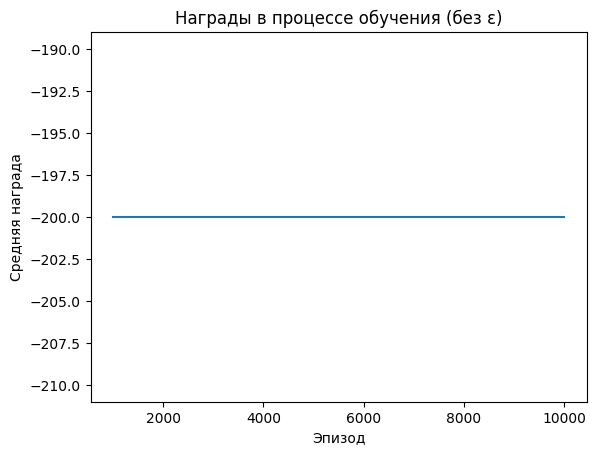

In [ ]:
print("Обучение с жадной стратегией (без ε)...")  # Начинаем обучение
optimal_Q_greedy, optimal_policy_greedy = mc_control_on_policy(env, gamma, n_episode)  # Учим без ε

In [ ]:
print("Оптимальная Q-функция (жадная):")  # Показываем Q
for state, q_values in list(optimal_Q_greedy.items())[:10]:
    print(f"Состояние {state}: {q_values}")
print("... (полный вывод опущен для краткости)")

Оптимальная Q-функция (жадная):
Состояние (np.int64(13), np.int64(15)): tensor([ -21.7278, -175.7269, -175.6550])
Состояние (np.int64(13), np.int64(14)): tensor([-65.1038, -88.7518, -16.2347])
Состояние (np.int64(12), np.int64(13)): tensor([ -84.2934, -154.5299,  -75.4015])
Состояние (np.int64(12), np.int64(12)): tensor([-65.1704, -56.9720, -73.5905])
Состояние (np.int64(11), np.int64(12)): tensor([-92.4170, -77.2705, -93.1846])
Состояние (np.int64(11), np.int64(11)): tensor([-59.1645, -52.5843, -76.5262])
Состояние (np.int64(10), np.int64(11)): tensor([-67.0024, -62.5520, -64.3242])
Состояние (np.int64(9), np.int64(11)): tensor([-58.9507, -66.7210, -62.5532])
Состояние (np.int64(8), np.int64(11)): tensor([-41.3601, -62.3763, -52.8127])
Состояние (np.int64(7), np.int64(11)): tensor([-33.0082, -20.7120, -28.4948])
... (полный вывод опущен для краткости)


In [ ]:
print("Оптимальная стратегия (жадная):")  # Показываем стратегию
for state, action in list(optimal_policy_greedy.items())[:10]:
    print(f"Состояние {state}: Действие {action}")
print("... (полный вывод опущен для краткости)")

Оптимальная стратегия (жадная):
Состояние (np.int64(13), np.int64(15)): Действие 0
Состояние (np.int64(13), np.int64(14)): Действие 2
Состояние (np.int64(12), np.int64(13)): Действие 2
Состояние (np.int64(12), np.int64(12)): Действие 1
Состояние (np.int64(11), np.int64(12)): Действие 1
Состояние (np.int64(11), np.int64(11)): Действие 1
Состояние (np.int64(10), np.int64(11)): Действие 1
Состояние (np.int64(9), np.int64(11)): Действие 0
Состояние (np.int64(8), np.int64(11)): Действие 0
Состояние (np.int64(7), np.int64(11)): Действие 1
... (полный вывод опущен для краткости)


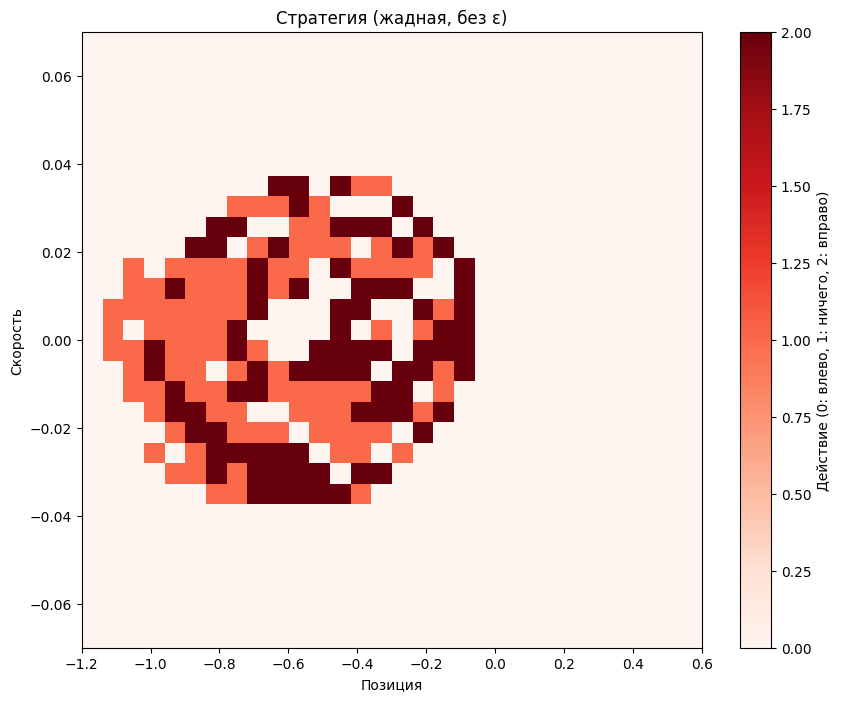

In [ ]:
plot_policy(optimal_policy_greedy, "Стратегия (жадная, без ε)")  # Рисуем карту действий

In [ ]:
avg_reward_greedy = evaluate_policy(env, optimal_policy_greedy, optimal_Q_greedy)  # Оцениваем
print(f"Средняя награда для жадной стратегии: {avg_reward_greedy}")  # Выводим результаты

Средняя награда для жадной стратегии: -200.0


## Обучение и вывод с ε:

И в финальной части кода выполним обучение агента, который выбирает лучшие действия без случайных шагов и показывает результаты. Выводит первые 10 значений *Q-функции* и стратегии, рисует карту действий. Показывает среднюю награду и длину эпизодов в конце:

Обучение с ε-жадной стратегией...
Эпизод 1000, средняя награда (с ε): -200.0
Эпизод 2000, средняя награда (с ε): -200.0
Эпизод 3000, средняя награда (с ε): -200.0
Эпизод 4000, средняя награда (с ε): -200.0
Эпизод 5000, средняя награда (с ε): -200.0
Эпизод 6000, средняя награда (с ε): -200.0
Эпизод 7000, средняя награда (с ε): -200.0
Эпизод 8000, средняя награда (с ε): -200.0
Эпизод 9000, средняя награда (с ε): -200.0
Эпизод 10000, средняя награда (с ε): -200.0


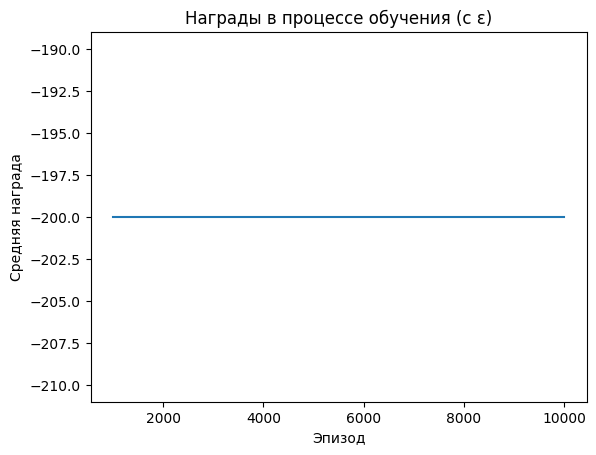

In [ ]:
print("Обучение с ε-жадной стратегией...")  # Начинаем обучение
optimal_Q_epsilon, optimal_policy_epsilon = mc_control_epsilon_greedy(env, gamma, n_episode, epsilon_start, epsilon_min, decay_rate)  # Учим с ε

In [ ]:
print("Оптимальная Q-функция (ε-жадная):")  # Показываем Q
for state, q_values in list(optimal_Q_epsilon.items())[:10]:
    print(f"Состояние {state}: {q_values}")
print("... (полный вывод опущен для краткости)")

Оптимальная Q-функция (ε-жадная):
Состояние (np.int64(13), np.int64(15)): tensor([-104.7151, -105.1044, -101.9075])
Состояние (np.int64(12), np.int64(14)): tensor([-105.5010, -111.0029, -111.6918])
Состояние (np.int64(12), np.int64(13)): tensor([ -96.4989, -102.1442, -102.1099])
Состояние (np.int64(11), np.int64(13)): tensor([-101.8456, -104.7720, -106.7553])
Состояние (np.int64(10), np.int64(13)): tensor([-100.9785, -100.6530,  -99.1605])
Состояние (np.int64(9), np.int64(13)): tensor([-65.5405, -69.1201, -54.2983])
Состояние (np.int64(8), np.int64(13)): tensor([-53.5123, -48.9555, -54.6797])
Состояние (np.int64(8), np.int64(14)): tensor([-58.6720, -46.3942, -58.8983])
Состояние (np.int64(8), np.int64(15)): tensor([-58.7164, -45.8551, -56.5189])
Состояние (np.int64(8), np.int64(16)): tensor([-45.8920, -53.8850, -52.6793])
... (полный вывод опущен для краткости)


In [ ]:
print("Оптимальная стратегия (ε-жадная):")  # Показываем стратегию
for state, action in list(optimal_policy_epsilon.items())[:10]:
    print(f"Состояние {state}: Действие {action}")
print("... (полный вывод опущен для краткости)")

Оптимальная стратегия (ε-жадная):
Состояние (np.int64(13), np.int64(15)): Действие 2
Состояние (np.int64(12), np.int64(14)): Действие 0
Состояние (np.int64(12), np.int64(13)): Действие 0
Состояние (np.int64(11), np.int64(13)): Действие 0
Состояние (np.int64(10), np.int64(13)): Действие 2
Состояние (np.int64(9), np.int64(13)): Действие 2
Состояние (np.int64(8), np.int64(13)): Действие 1
Состояние (np.int64(8), np.int64(14)): Действие 1
Состояние (np.int64(8), np.int64(15)): Действие 1
Состояние (np.int64(8), np.int64(16)): Действие 0
... (полный вывод опущен для краткости)


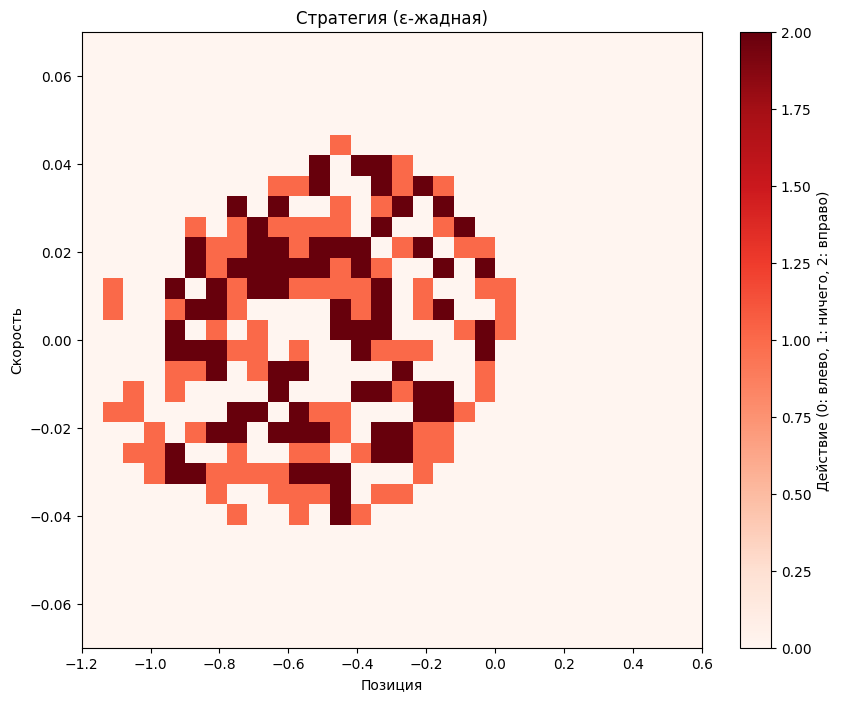

In [ ]:
plot_policy(optimal_policy_epsilon, "Стратегия (ε-жадная)")  # Рисуем карту действий

In [ ]:
avg_reward_epsilon = evaluate_policy(env, optimal_policy_epsilon, optimal_Q_epsilon)  # Оцениваем
print(f"Средняя награда для ε-жадной стратегии: {avg_reward_epsilon}")  # Выводим результаты

Средняя награда для ε-жадной стратегии: -200.0


## Анализ получившихся результатов:

### Жадная стратегия (без ε):

---

1.   **Средняя награда** =  -200.0. Это указывает, что агент не достигает цели, так как награда -1 за каждый шаг умножается на максимальную длину эпизода (200 шагов). Агент застревает в низине, не находя оптимальный путь;
2.   **Q-функция** меняется медленно, так как отсутствие исследования (ε = 0) ограничивает посещение новых состояний. Значения остаются высокие и отрицательные, отражая длинные эпизоды без цели. Стратегия формируется только на основе уже посещённых состояний, что приводит к застреванию в локальных минимумах;
3.   **Стратегия:** Действия (0: влево, 1: ничего, 2: вправо) распределяются неравномерно (например, 1 и 0 доминируют), но без чёткого паттерна, указывающего на отсутствие эффективной политики.

### ε-жадная стратегия:

---

1.   **Средняя награда** = -200.0. Как и в случае без **ε**, агент не достигает цели, что может указывать на недостаток эпизодов (10 000) для сходимости или слабую настройку параметров (например, **ε-decay**);
2.   **Q-функция** обновляется шире благодаря случайным действиям, что позволяет исследовать больше состояний. Разница между действиями меньше, что указывает на попытку агента найти оптимальные пути, хотя награда всё ещё отрицательная. Стратегия показывает признаки качания (переключение между 0 и 2), но не завершает задачу;
3.   **Стратегия:** Преобладание действия 2 (вправо) в некоторых состояниях и 0 (влево), в других  намекает на формирование паттерна качания, хотя ещё не достаточно развитого для успеха.

### Вывод:

*ε-жадная стратегия* положительно влияет на обучение, обеспечивая большее разнообразие действий и лучшее начальное исследование, но текущие параметры не достаточны для успеха в **MountainCar**.